# Import packages

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from datetime import datetime, time, date

import matplotlib.pyplot as plt
from rsi import rsi

# Import data and pre-process

In [2]:
df=pd.read_csv(r"Asian_paints_15Y.csv",index_col="Date",parse_dates=True)      #Training data
dfv=pd.read_csv(r"HINDUUNI_15Y.csv",index_col="Date",parse_dates=True)       #Validation/test data

# Between period FY 2014-20 the indian markets experienced a boom, and the volatilty in the market also increased significantly
# Since the data before FY 2014 the had very low volatility, the amount of data available for training from the high volatility years was very limited, 
# which created a error in the validation set.
# To avoid this I have selected two large cap stocks whose performance were similar over the period under consideration.

In [3]:
df=df.dropna()        #Drop NA values from the data frame
dfv=dfv.dropna()   #Drop NA values from the data frame

In [4]:
df1=df[['Close']].copy()   #Initiating the data-frame
df1_rsi=rsi(df)                    #Get the RSI values for the data
df1["rsi"]=df1_rsi.iloc[:,6] #Create the final dataframe with Close price and RSI values

dfv1=dfv[['Close']].copy()  #Initiating the data-frame
dfv1_rsi=rsi(dfv)                   #Get the RSI values for the data
dfv1["rsi"]=dfv1_rsi.iloc[:,6] #Create the final dataframe with Close price and RSI values

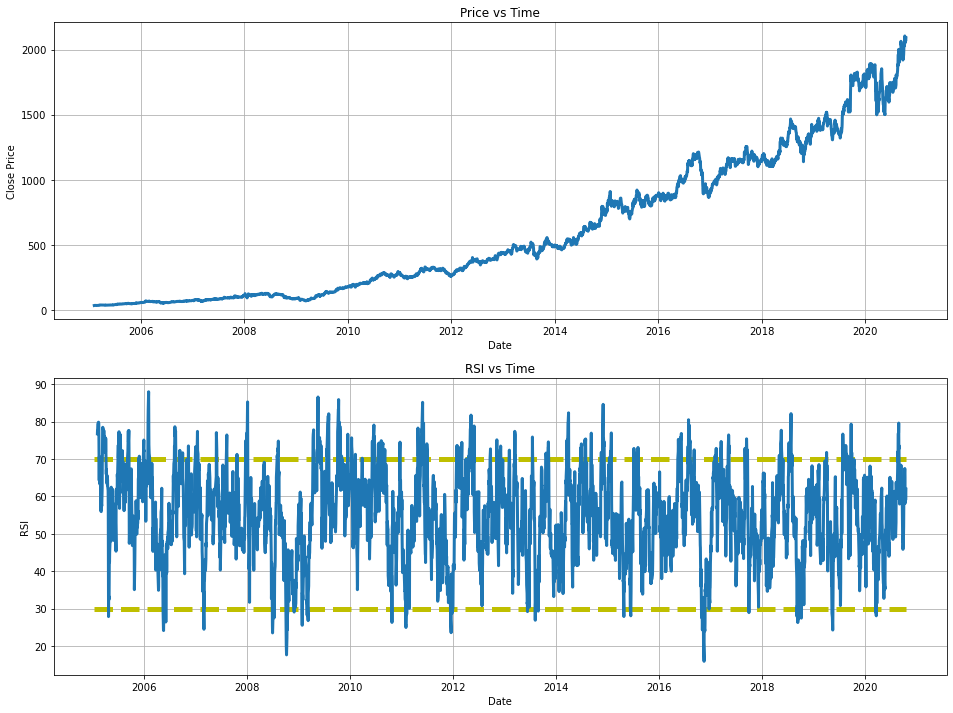

In [5]:
dates=df.index
plt.figure(figsize=(16,12))

plt.subplot(2,1,1)
plt.plot(dates[14:],df1.iloc[14:,0].values, linewidth =3)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title("Price vs Time")
plt.grid()

plt.subplot(2,1,2)
plt.plot(dates[14:],df1.iloc[14:,1].values, linewidth =3)
plt.xlabel('Date')
plt.ylabel('RSI')
plt.hlines(70,dates[0],dates[-1],color="y",linestyles="dashed", linewidth =5)
plt.hlines(30,dates[0],dates[-1],color="y",linestyles="dashed", linewidth =5)
plt.title("RSI vs Time")
plt.grid()

# Feature scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc1=MinMaxScaler(feature_range=(0,1))                       #Feature scaling for  price
sc2=MinMaxScaler(feature_range=(0,1))                      #Feature scaling for RSI

df2=sc1.fit_transform(np.array(df1.iloc[14:,0]).reshape(-1,1))         #Scaling Price
df2_rsi=sc2.fit_transform(np.array(df1.iloc[14:,1]).reshape(-1,1))   #Scaling RSI
df2=np.append(df2,df2_rsi,axis=1)                                 #Combinng both scaled dataframes

dfv2=sc1.transform(np.array(dfv1.iloc[14:,0]).reshape(-1,1))   #Scaling Price
dfv2_rsi=sc2.transform(np.array(dfv1.iloc[14:,1]).reshape(-1,1))  #Scaling RSI
dfv2=np.append(dfv2,dfv2_rsi,axis=1)                                                    #Combinng both scaled dataframes

# Creating dataset

In [7]:
#Intializing train data and test data.
training_size=int(len(df1))
training_data=df2[0:training_size,:]

test_size=(len(dfv1))
test_data=dfv2[0:test_size,:]


In [8]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, timestep):
    dataY = []
    dataX=[]
    for i in range (len(dataset)-timestep-1):
        a=dataset[i:(i+timestep),:]                         #Ex - storing the values from 1 to 100
        dataX.append(a)
        dataY.append(dataset[i+timestep, 0])     #Ex - The output will be 101st day closing price
    return  np.array(dataX), np.array(dataY)

In [9]:
# creating train data and test data
timestep=100                                                      #Using data from previous 100 days
X_train, Y_train =create_dataset(training_data, timestep)
X_test, Y_test = create_dataset(test_data, timestep)

# the test set will be ==>  from (total - timestep-1) to (total-1)  


# Creating model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

In [ ]:
model =Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1],2)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))

model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam",metrics=[tf.keras.metrics.RootMeanSquaredError(
    name="root_mean_squared_error", dtype=None
)])

In [ ]:
model.summary()

## Loading the pre-trained model

In [12]:
from tensorflow.keras.models import load_model
model=load_model('RSI_model.model')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_32 (Bidirectio (None, 100, 100)          21200     
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 100, 100)          60400     
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 100, 100)          60400     
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 202,501
Trainable params: 202,501
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [ ]:
model_history=model.fit(X_train,Y_train,validation_data =(X_test, Y_test), 
                    epochs=60, 
                    batch_size=32,
                   verbose=1)   # Training is done in google colab

### To save the trained model

In [ ]:
model.save("RSI_model.model",save_format="h5") 

## Learning Curves

In [ ]:
plt.plot(model_history.history['root_mean_squared_error'])
plt.plot(model_history.history['val_root_mean_squared_error'])
plt.legend(['train','validation'])
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.legend(['train','validation'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Validation

In [13]:
train_predict=model.predict(X_train)    #Model prediction for test set
test_predict= model.predict(X_test)       #Model prediction for test/validation set
X_train.shape, train_predict.shape

((3763, 100, 2), (3763, 1))

In [14]:
# Scale back the predictions to original values (Initally we had scaled down to range 0-1)
train_predict =sc1.inverse_transform(train_predict)
test_predict =sc1.inverse_transform(test_predict)
Y_train=sc1.inverse_transform(Y_train.reshape(-1,1))
Y_test=sc1.inverse_transform(Y_test.reshape(-1,1))

In [15]:
## Performance Metrics (RMSE)
import math 
from sklearn.metrics import mean_squared_error
train_rmse = math.sqrt(mean_squared_error(Y_train,train_predict))

## Test data RMSE
test_rmse = math.sqrt(mean_squared_error(Y_test,test_predict))

train_rmse, test_rmse

(15.161468782809054, 17.70753062717811)

train end at  3863
test start at 3964
test end at 3863
Test length -101
The shape of X_test 3761


<Figure size 576x216 with 0 Axes>

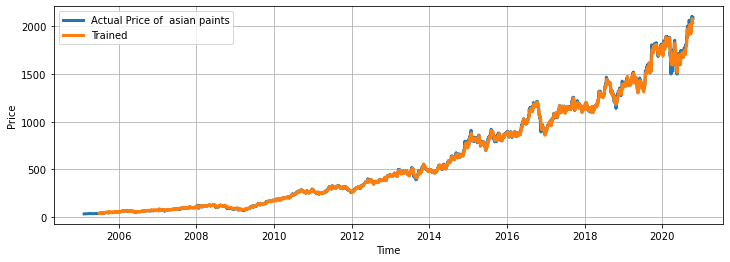

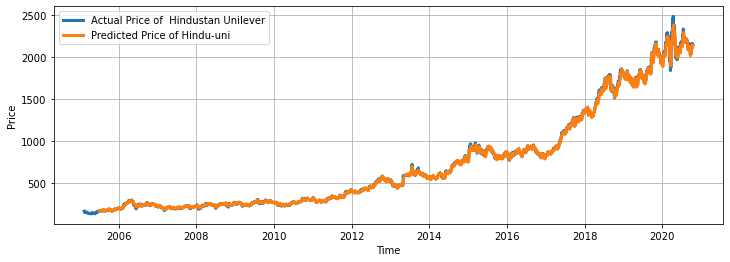

In [18]:
dates= df[:].index
datesv=dfv1[:].index
plt.figure(figsize=(8,3))
look_back=100
# Shift train predictions for plotting
trainplot=np.empty_like(df2[:,0]).reshape(-1,1)
trainplot[:, :] =np.nan
trainplot[look_back:len(train_predict)+look_back, :] = train_predict   
print("train end at ",len(train_predict)+look_back)

# Shift test predictions for plotting
testplot=np.empty_like(dfv2[:,0]).reshape(-1,1)
testplot[:, :] =np.nan

print("test start at",len(train_predict)+2*look_back+1)
print("test end at",len(df2)-1)
print("Test length",len(df2)-1-(len(train_predict)+2*look_back+1))
print("The shape of X_test",X_test.shape[0])

testplot[look_back:len(test_predict)+look_back, :] = test_predict     
#2*look_back covers the previous the previous 100 timesteps data included in training/testing the model
# For testing the data will come from (len(train_predict+look_back) : len(train_predict+2*look_back) ) 
#==> the first prediction will come at [len(train_predict)+2*look_back+1]

# Plotting baseline and predictions
plt.figure(figsize=(12,4))
plt.plot(dates,(np.array(np.array(sc1.inverse_transform(df2[:,0].reshape(-1,1))))),label ="Actual Price of  asian paints",linewidth=3 )
plt.plot(dates,trainplot,label="Trained",linewidth=3)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(datesv,(np.array(np.array(sc1.inverse_transform(dfv2[:,0].reshape(-1,1))))),label ="Actual Price of  Hindustan Unilever",linewidth=3)
plt.plot(datesv,testplot,linewidth=3, label ="Predicted Price of Hindu-uni")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Prediction

In [19]:
# TO be used in prediction step
def update_rsi_df(df1, df1_rsi):
    diff = df1.iloc[-1, 0] - df1.iloc[-2, 0]  # Calculate the difference first

    ##Check if it is a gain or loss

    # Gain
    if diff > 0:
        Gain = diff
        Loss = 0
    # Loss

    elif diff < 0:
        Loss = -1 * diff
        Gain = 0
    else:
        Gain = 0
        Loss = 0

# Update the Avg gain and Avg loss using the previous Avg gain values and latest Gains
    Avg_gain = (df1_rsi.iloc[-1, 3] * 13 + Gain) / 14

    Avg_loss = (df1_rsi.iloc[-1, 4] * 13 + Loss) / 14

# Calculate Relative strength
    RS = Avg_gain / Avg_loss

# Calculate RSI
    RSI = 100 - (100 / (1 + RS))

    df1.iloc[-1, 1] = RSI

# Append all the values to the data frame used for calculating RSI
# This updated dataframe will be used in next step
    df1_rsi = df1_rsi.append({'Close': Price, 'Gain': Gain, 'Loss': Loss, 'Avg gain': Avg_gain,
                          'Avg loss': Avg_loss, 'RS': RS, 'RSI': RSI}, ignore_index=True)
    return df1_rsi, RSI

In [26]:
x_input=test_data[len(test_data)-timestep: , :].reshape(-1,2)#Taking previous day 100 data
                                                                                                                    # test data contains close price and rsi
x_input.shape

(100, 2)

In [27]:
temp_input=list(x_input)

In [28]:
from numpy import array
list_output=[] #Empty list

i=0
n_steps=100

while (i<30):
    if (len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(-1,2)
        x_input=x_input.reshape((1,n_steps,2))
        yhat=model.predict(x_input,verbose=0)
        yhat.tolist()

        Price=sc1.inverse_transform(yhat)[0][0]  
        dfv1=dfv1.append({'Close':Price,'rsi':'NaN'},ignore_index=True)
        dfv1_rsi,RSI=update_rsi_df(dfv1,dfv1_rsi)

      # Rescaling price and RSI for next step
        Price=sc1.transform(np.array(Price).reshape(-1,1))[0][0]
        RSI=sc2.transform(np.array(RSI).reshape(-1,1))[0][0]

        temp_input.append(np.array([Price,RSI]))
        temp_input=temp_input[1:]
        list_output.append(Price)
        i=i+1    

    else :
        x_input=x_input.reshape((1,n_steps,2))        #At first iteration step
        yhat=model.predict(x_input,verbose=0)       #Predict at 101th day
        yhat.tolist()
        Price=sc1.inverse_transform(yhat)[0][0]
        dfv1=dfv1.append({'Close':Price,'rsi':'NaN'},ignore_index=True)
        dfv1_rsi,RSI=update_rsi_df(dfv1,dfv1_rsi)         #Update RSI table

        # Rescaling price and RSI for next step
        Price=sc1.transform(np.array(Price).reshape(-1,1))[0][0]
        RSI=sc2.transform(np.array(RSI).reshape(-1,1))[0][0]

        temp_input.append(np.array([Price,RSI]))
        list_output.append(Price)
        i=i+1


print(list_output)

[1.0140184, 1.031972, 1.0404122, 1.0418688, 1.0398307, 1.0362973, 1.032261, 1.0287699, 1.0261656, 1.0247651, 1.0244869, 1.0253327, 1.0268142, 1.0286226, 1.0305313, 1.032207, 1.0337652, 1.035033, 1.0363315, 1.0371767, 1.0379103, 1.0381577, 1.038117, 1.0375997, 1.0361515, 1.032904, 1.0268036, 1.0162331, 1.0003664, 0.9811308]


In [29]:
list_output=np.array(list_output).reshape(-1,1)
Preds=sc1.inverse_transform(list_output)

In [30]:
df3=dfv2.tolist()
df3.extend(list_output) # adding the latest output to the existing data
df3[-1]

array([0.9811308], dtype=float32)

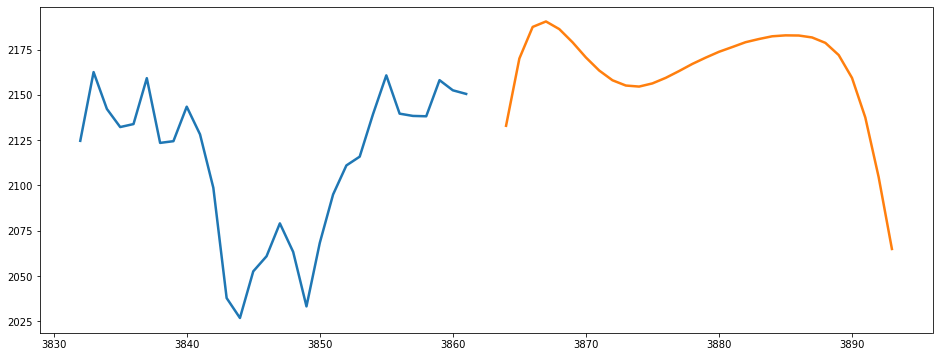

In [44]:
plt.figure(figsize=(16,6))

timeframe_prev =list(range(len(dfv2)-30, len(dfv2)))
plt.plot(timeframe_prev,sc1.inverse_transform(dfv2[len(dfv2)-30:,0].reshape(-1,1)), label="Price till 26th Sept",linewidth=2.5) 

timeframe =list(range(len(df2), len(df2)+30))
plt.plot(timeframe,sc1.inverse_transform(list_output.reshape(-1,1)), label="Predicted price in next 30 trading sessions",linewidth=2.5)

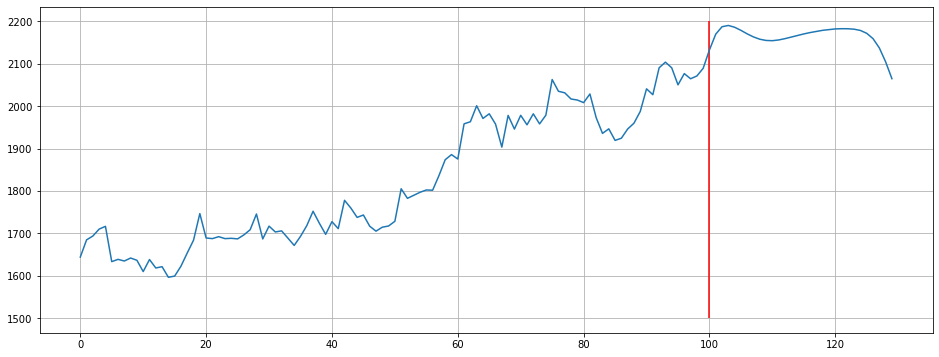

In [48]:
plt.figure(figsize=(16,6))
df3=df2[:,0].tolist()
df3.extend(list_output)
plt.plot(sc1.inverse_transform(np.array(df3[len(df2)-100:]).reshape(-1,1)))
plt.vlines(100,1500,2200,color='r')
plt.grid()

# Thank You!